## Package import

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import sampler, TensorDataset, Dataset

import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import imgaug as ia
import pandas as pd
from pandas import Series
import random
import scipy
import cv2
import time
import scipy.signal
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error, r2_score

## Meta data

In [2]:
df = pd.read_csv('/data/put_data/timliu/BG/new_IRB_summary_1457_1020.csv')
print(df.shape[0])
df[:5]

2914


,Unnamed: 0,Unnamed: 0.1,Person No,Age,Gender,Height,SYS,DIA,HR,G,...,BMI,BP_drug,DM,DM_drug,O_drug,W_cir,weight,ID,Date,Time
0,0,1,1,60,0,156.0,90,63,77,115,...,16.6,0,0,0,0,61.5,40.5,001_1_m,20170302,1124
1,1,2,1,60,0,156.0,88,60,74,114,...,16.6,0,0,0,0,61.5,40.5,001_2_m,20170302,1130
2,2,3,2,62,0,155.0,115,78,73,108,...,24.7,0,0,0,0,80.0,59.4,002_1_m,20170302,1150
3,3,4,2,62,0,155.0,115,79,74,111,...,24.7,0,0,0,0,80.0,59.4,002_2_m,20170302,1154
4,4,5,3,53,0,157.0,147,96,77,143,...,25.4,0,0,0,1,83.0,62.7,003_1_m,20170302,1203


## Check distribution

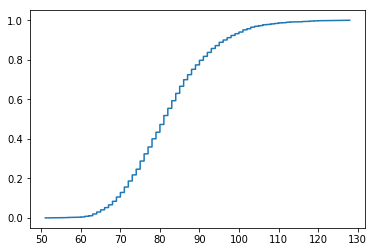

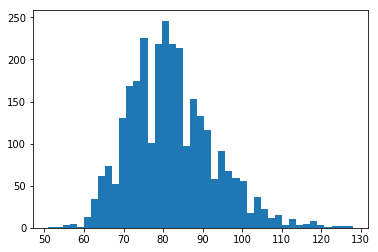

In [3]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(df.DIA.values)
plt.plot(ecdf.x, ecdf.y)
plt.show()
plt.hist(df.DIA.values, bins='auto')
plt.show()
plt.close()

## Signal data

In [4]:
import pickle
with open('/data/put_data/timliu/BG/1006_data/dict_X_C10_1020_final.pickle', 'rb') as h:
    X = pickle.load(h)

## Training & Testing 

In [5]:
# split data every-step = 10 
ratio = 0.785
random.seed(60)
train_id = []
for i in range(6, 49):
    df_sub = df[df['G'].between(10*i, 10*(i+1), inclusive = (True, False))]
    d_list = Series.tolist(df_sub['ID'])
    random.shuffle(d_list)
    train_id += d_list[:int(ratio*len(d_list))]
train_id = list(set(train_id))
test_id = [id_ for id_ in df['ID'].values if id_ not in train_id]
print(len(train_id))
print(len(test_id))

2305
609


## Changing dtype

In [6]:
torch.cuda.set_device(0)
# specify dtype
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
print(torch.cuda.device_count())

True
2


## Data generator

In [7]:
class GG_Dataset(Dataset):
    def __init__(self, id_list, input_len, transform):
        self.id_list = id_list
        self.input_len = input_len
        self.transform = transform
    def __getitem__(self, index):
        sig = X[self.id_list[index]][:40000, :5]
        sig = scipy.signal.resample(sig, 8000, axis = 0)
        start = random.randint(0, int(8000-1000))
        sig = sig[start:start+1000, :]
        label = df[df['ID'] == self.id_list[index]]['DIA'].values[0]
        sig = np.expand_dims(sig, axis = 0)
        return sig, label
    def __len__(self):
        return len(self.id_list)

In [8]:
# sig = X['003_1'][:, :5]
# sig = scipy.signal.resample(sig, 4000, axis = 0)
# plt.plot(sig[:500, 0])
# plt.show()
# plt.close()

## Some parameters

In [9]:
# parameter
input_len = 1000
batch_size = 128
learning_rate = 5e-5
num_epoch = 300

In [10]:
train_MDFA_dataset = GG_Dataset(train_id, input_len, transform = True)
test_MDFA_dataset = GG_Dataset(test_id, input_len, transform = False)

trainloader = torch.utils.data.DataLoader(train_MDFA_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_MDFA_dataset, batch_size=len(test_id), shuffle=False, num_workers=4)

In [11]:
# trainloader testing
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
# print(images.shape)

## Model architecture

In [12]:
class conv_block(nn.Module):
    def __init__(self, inplane, outplane, kernel_size, stride, downsample=False):
        super(conv_block, self).__init__()
        self.downsample = downsample
        self.indentity = nn.Conv2d(inplane, outplane, kernel_size=kernel_size, stride=1, bias=False, padding=(7,0))
        self.maxpool = nn.MaxPool2d((2, 1), stride=(2, 1), ceil_mode=True)
        self.bn1 = nn.InstanceNorm2d(inplane)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(p=0.2)
        self.conv1 = nn.Conv2d(inplane, outplane, kernel_size=kernel_size, stride=stride, padding=(7,0))
        self.bn2 = nn.InstanceNorm2d(outplane)
        self.conv2 = nn.Conv2d(outplane, outplane, kernel_size=kernel_size, stride=1, padding=(7,0))
    def forward(self, x1):
        if self.downsample:
            residual = self.maxpool(x1)
        else:
            residual = self.indentity(x1)
        out = self.bn1(x1)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.conv2(out)
        out += residual
        return out

In [13]:
class QQ_model(nn.Module):
    def __init__(self, filters, kernel_size):
        super(QQ_model, self).__init__()
        self.conv_1 = nn.Conv2d(1, filters, kernel_size=kernel_size, stride=(1, 1), padding=(7,0))
        self.bn_1 = nn.InstanceNorm2d(filters)
        self.relu = nn.ReLU()
        self.maxpool_1 = nn.MaxPool2d((2, 1), stride=(2, 1))
        self.conv_2 = nn.Conv2d(filters, filters, kernel_size=kernel_size, stride=(2, 1), padding=(7,0))
        self.bn_2 = nn.InstanceNorm2d(filters)
        self.conv_3 = nn.Conv2d(filters, filters, kernel_size=kernel_size, stride=(1, 1), padding=(7,0))
        self.block_1 = self.make_layer(conv_block, filters, 128, kernel_size)
        self.block_2 = self.make_layer(conv_block, 128, 192, kernel_size)
        self.block_3 = self.make_layer(conv_block, 192, 256, kernel_size)
        self.block_4 = self.make_layer(conv_block, 256, 320, kernel_size)
        self.block_5 = self.make_layer(conv_block, 320, 384, kernel_size)
        self.block_6 = self.make_layer(conv_block, 384, 448, kernel_size)
        self.fc = nn.Sequential(
            nn.Linear(17920, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 1)
        )
        
    def make_layer(self, block, inplane, outplane, kernel_size):
        out = nn.Sequential(
            block(inplane, outplane, kernel_size, stride=(1, 1), downsample=False),
            block(outplane, outplane, kernel_size, stride=(2, 1), downsample=True))
        return out
    
    def forward(self, x1):
        out = self.conv_1(x1)
        out = self.bn_1(out)
        out = self.relu(out)
        
        shortcut = self.maxpool_1(out)
        out2 = self.conv_2(out)
        out2 = self.bn_2(out2)
        out2 = self.conv_3(out2)
        out2 += shortcut
        
        out2 = self.block_1(out2)
        out2 = self.block_2(out2)
        out2 = self.block_3(out2)
        out2 = self.block_4(out2)
        out2 = self.block_5(out2)
        out2 = self.block_6(out2)
        out2 = out2.view(out2.size(0), -1)
#         print(out2.size())
        out2 = self.fc(out2)
        return out2

In [14]:
model = QQ_model(64, (15, 1)).type(dtype)
net = torch.nn.DataParallel(model)

In [15]:
# # # test
# t1 = Variable(torch.rand(10, 1, 1000, 5)).type(dtype)
# model(t1)

In [16]:
def plot_losses(loss_history1=None, loss_history2=None):
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if loss_history1:
        ax1.plot(loss_history1, color="blue", label="train")
    if loss_history2:
        ax1.plot(loss_history2, color="orange", label="test")
    #ax2 = ax1.twinx()
    #ax2.set_yscale('log')
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    plt.legend(bbox_to_anchor=(0.8, 0.9), loc=2, borderaxespad=0.)
    plt.title("loss")
    plt.savefig(model_dir + 'output_losses.png')
    plt.close()

## Optimizers & directory

In [17]:
# loss and optimizer
criterion = nn.MSELoss()
criterion2 = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10,verbose=True)
# model dir
time_str = time.strftime("%m%d")
model_dir = 'model_for_prediction/' + time_str + '/andrew_d2/' 
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
print('model will be saved to ', model_dir)

model will be saved to  model_for_prediction/1226/andrew_d2/


## Training process

In [18]:
for i, tdata in enumerate(testloader, 0):
    tinputs1, tlabels = tdata
    tinputs1, tlabels = Variable(tinputs1, volatile=True).type(dtype), Variable(tlabels, volatile=True).type(dtype)

In [19]:
train_loss = []
test_loss_l1 = []
test_loss = []
patience = 0
best_loss = float('Inf')

# start training
for epoch in range(num_epoch):  # loop over the dataset multiple times
    running_loss1 = []
    running_loss2 = []
    running_loss3 = []
    tStart = time.time()

    for i, data in enumerate(trainloader, 0):
        net.train(True)    
        # get the inputs
        inputs1, labels = data
        # wrap them in Variable
        inputs1, labels = Variable(inputs1).type(dtype), Variable(labels).type(dtype)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        # loss
        running_loss1.append(loss.data[0])

    net.train(False)
    toutput = net(tinputs1)
    tloss = criterion(toutput, tlabels)
    tloss_l1 = criterion2(toutput, tlabels)
    running_loss2.append(tloss.data[0])
    running_loss3.append(tloss_l1.data[0])

    scheduler.step(np.mean(running_loss2))
    
    train_loss.append(np.mean(running_loss1))
    test_loss.append(np.mean(running_loss2))
    test_loss_l1.append(np.mean(running_loss3))
    
    tEnd = time.time()
    
    #statistics
    print('Epoch [%d/%d], Train Loss:%.3f, Test Loss:%.3f, Test Loss l1:%.3f, Time:%.3f' 
                %(epoch+1, num_epoch, train_loss[-1], test_loss[-1], test_loss_l1[-1], (tEnd - tStart)))

    #early stopping
    if epoch > 20:
        if test_loss[-1] < best_loss:
            best_loss = test_loss[-1]
            torch.save(net.state_dict(), model_dir + 'model.pkl')
            patience = 0
        else:
            patience += 1
            
        if patience > 50:
            print('Early stopping')
            break
        # loss history 
    if epoch % 10 == 0 and epoch != 0:
        plot_losses(train_loss, test_loss)
    
print('Finished Training')

Epoch [1/300], Train Loss:1561.113, Test Loss:217.988, Test Loss l1:12.548, Time:20.927
Epoch [2/300], Train Loss:123.930, Test Loss:119.951, Test Loss l1:8.746, Time:15.274
Epoch [3/300], Train Loss:113.639, Test Loss:112.392, Test Loss l1:8.382, Time:15.074
Epoch [4/300], Train Loss:116.229, Test Loss:160.309, Test Loss l1:10.710, Time:14.941
Epoch [5/300], Train Loss:106.787, Test Loss:206.481, Test Loss l1:12.444, Time:14.933
Epoch [6/300], Train Loss:117.850, Test Loss:110.593, Test Loss l1:7.900, Time:15.027
Epoch [7/300], Train Loss:112.775, Test Loss:156.210, Test Loss l1:9.483, Time:15.082
Epoch [8/300], Train Loss:134.681, Test Loss:108.884, Test Loss l1:8.272, Time:15.153
Epoch [9/300], Train Loss:126.048, Test Loss:248.119, Test Loss l1:13.726, Time:15.238
Epoch [10/300], Train Loss:123.179, Test Loss:103.739, Test Loss l1:7.751, Time:15.242
Epoch [11/300], Train Loss:111.179, Test Loss:113.868, Test Loss l1:8.643, Time:15.541
Epoch [12/300], Train Loss:92.256, Test Loss:20

Epoch [95/300], Train Loss:73.046, Test Loss:75.411, Test Loss l1:6.964, Time:15.450
Epoch [96/300], Train Loss:72.278, Test Loss:75.340, Test Loss l1:6.960, Time:15.349
Epoch [97/300], Train Loss:71.026, Test Loss:75.004, Test Loss l1:6.941, Time:15.473
Epoch    97: reducing learning rate of group 0 to 5.0000e-09.
Epoch [98/300], Train Loss:81.408, Test Loss:74.892, Test Loss l1:6.934, Time:15.692
Epoch [99/300], Train Loss:68.924, Test Loss:74.811, Test Loss l1:6.930, Time:15.514
Epoch [100/300], Train Loss:70.878, Test Loss:74.773, Test Loss l1:6.927, Time:15.532
Epoch [101/300], Train Loss:72.044, Test Loss:74.756, Test Loss l1:6.926, Time:15.545
Epoch [102/300], Train Loss:72.164, Test Loss:74.719, Test Loss l1:6.924, Time:15.660
Epoch [103/300], Train Loss:72.194, Test Loss:74.711, Test Loss l1:6.924, Time:15.535
Epoch [104/300], Train Loss:72.471, Test Loss:74.676, Test Loss l1:6.922, Time:15.725
Epoch [105/300], Train Loss:75.618, Test Loss:74.654, Test Loss l1:6.921, Time:15.4

## Model Evaluation

In [20]:
net.load_state_dict(torch.load(model_dir+ 'model.pkl'))

In [21]:
plot_losses(train_loss, test_loss)

In [22]:
def plot_making(true, pred, types):
    cor = pearsonr(true, pred)[0]
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred) 
    plt.figure(0)
    plt.scatter(true, pred, alpha = .15, s = 20)
    plt.xlabel('True_Y')
    plt.ylabel('Pred_Y')
    plt.title(" data \n" + "MAE = %4f; Cor = %4f; R2 = %4f; #samples = %d" % (mae, cor, r2, len(true)))
    plt.savefig(model_dir + types + "_plot_scatter.png" , dpi = 200)
    plt.show()
    plt.close()

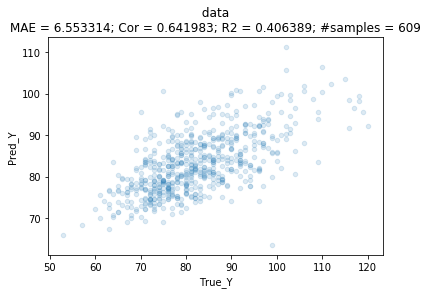

L1 Loss on test images: 69.79425048828125


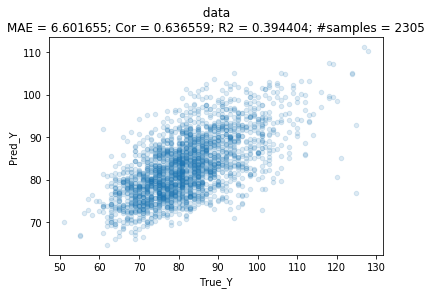

L1 Loss on test images: 70.043006294652031


In [23]:
def loss_generator(testloader, model, types):
    test_loss = []
    true = []
    pred = []
    for i, tdata in enumerate(testloader, 0):
        tinputs1, tlabels = tdata
        tinputs1, tlabels = Variable(tinputs1, volatile=True).type(dtype), Variable(tlabels, volatile=True).type(dtype)
        toutput = net(tinputs1)
        tloss = criterion(toutput, tlabels)
        test_loss.append(tloss.data[0])
        true.extend(tlabels.data.cpu().numpy())
        pred.extend(toutput.data.cpu().numpy())
    true = np.asarray(true)
    true = np.expand_dims(true, axis=1)
    pred = np.asarray(pred)
    plot_making(true, pred, types = types)
    print('L1 Loss on test images: %r' % (np.mean(test_loss)))
    
train_dataset = GG_Dataset(train_id, df, transform = False)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
loss_generator(testloader, net.eval(), types = 'test')
loss_generator(trainloader, net.eval(), types = 'train')